In [17]:
import glob
import copy
import pyorc
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [18]:
np.random.seed(0)

MONTHS = ['January', 'February', 'March', 'April', 'May', 'June', 'July']

files = []
for month in MONTHS:
    for file in sorted(glob.glob("*.nc", root_dir=f"{month}/results/")):
        files.append({
            "video_file": f"{month}/videos/{file.split('.')[0].rsplit('_', maxsplit=2)[0]}.mp4",
            "vector_file": f"{month}/results/{file}"
        })

# for f in files:
#     print(f)

files = np.random.choice(np.array(files), size=len(files)//10, replace=False)

In [19]:
radar = pd.read_csv('radar/test1.csv')

radar_mean = np.mean(radar[radar['Tilt angle value'] >= 60][' Average velocity value'])
print(f"radar mean velocity: {radar_mean}")

radar mean velocity: 1.6031746031746033


In [20]:
# file = files[1]
file = {'video_file': 'July/videos/video_capture_2024-07-01_12-22-37.mp4', 'vector_file': 'July/results/video_capture_2024-07-01_12-22-37_velocimetry_results.nc'}
video_file = file['video_file']
vector_file = file['vector_file']

dataset = xr.open_dataset(vector_file)

/home/waterlab/anaconda3/envs/pyorc/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/waterlab/anaconda3/envs/pyorc/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


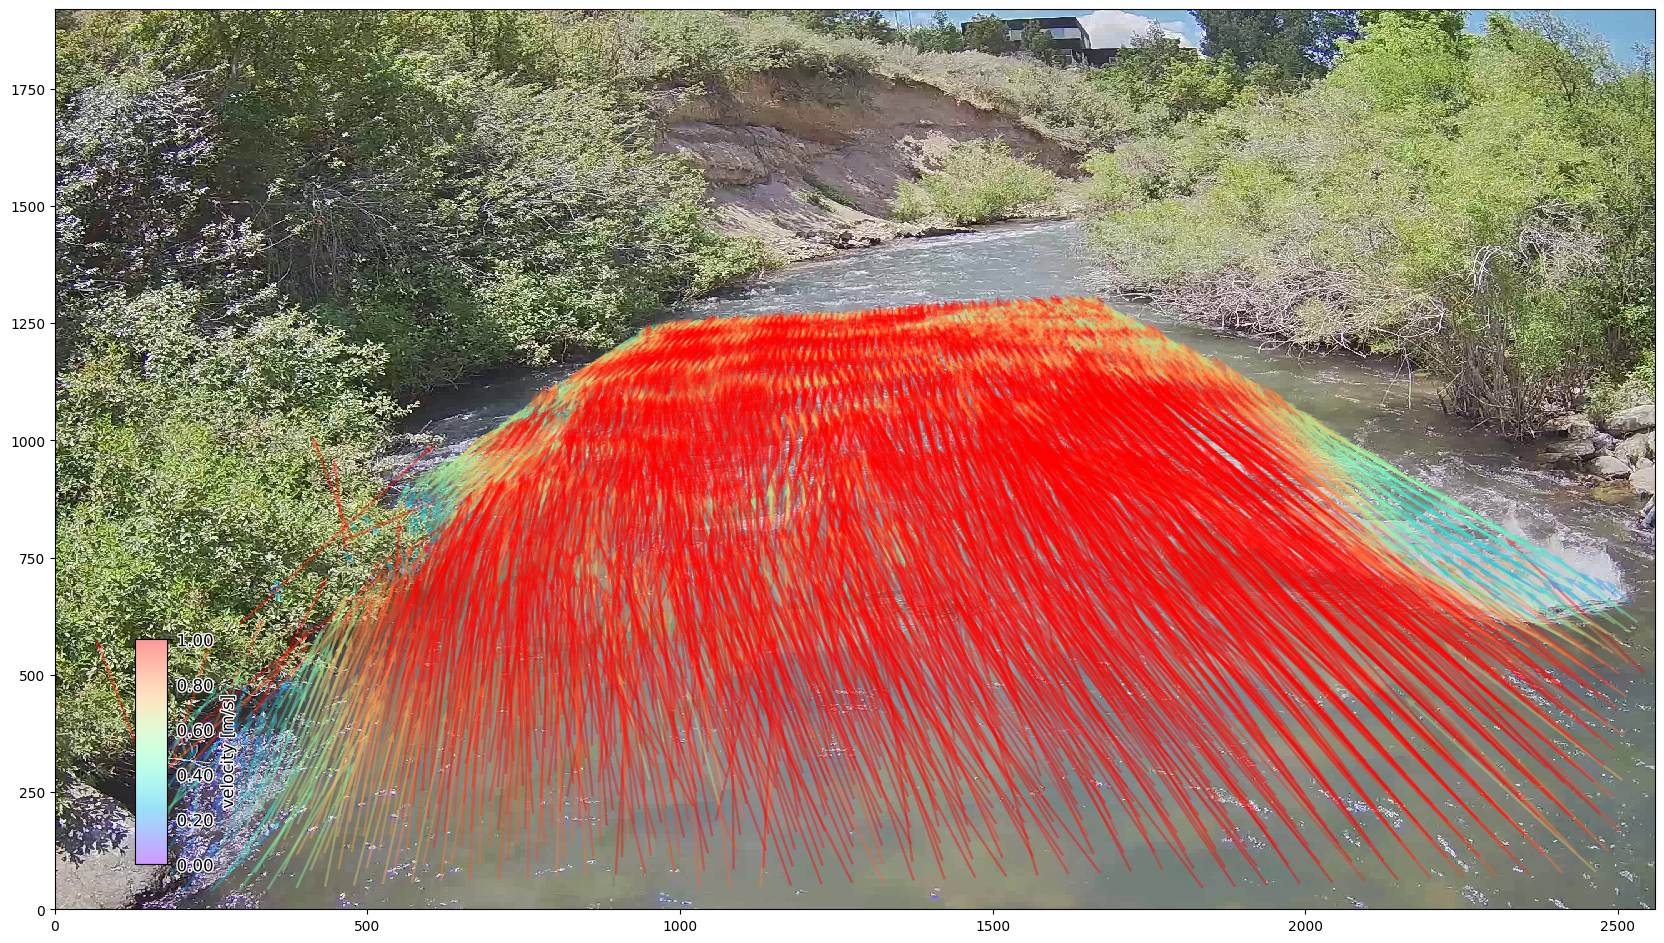

<Figure size 640x480 with 0 Axes>

In [28]:
ds = copy.deepcopy(dataset)

ds.velocimetry.mask.corr(tolerance=0.2, inplace=True)
# ds.velocimetry.mask.corr(inplace=True)
ds.velocimetry.mask.minmax(inplace=True)
# ds.velocimetry.mask.rolling(inplace=True)
ds.velocimetry.mask.outliers(inplace=True)
ds.velocimetry.mask.angle(inplace=True)
ds.velocimetry.mask.variance(inplace=True)
# ds.velocimetry.mask.count(inplace=True)

ds.velocimetry.mask.window_mean(wdw=2, inplace=True, tolerance=0.5, reduce_time=True)

video = pyorc.Video(video_file, start_frame=0, end_frame=125)
video.camera_config = ds.velocimetry.camera_config

ds = ds.mean(dim="time", keep_attrs=True)

ds.velocimetry.plot(
    ax=video.get_frames(method="rgb")[0].frames.plot(mode="camera").axes,
    mode="camera",
    alpha=0.4,
    cmap="rainbow",
    scale=200,
    width=0.0015,
    norm=Normalize(vmin=0., vmax=1.0, clip=False),
    add_colorbar=True
)
plt.show()
plt.clf()

pyorc vector length mean: 0.957947168457282


<Axes: xlabel='v_len', ylabel='Count'>

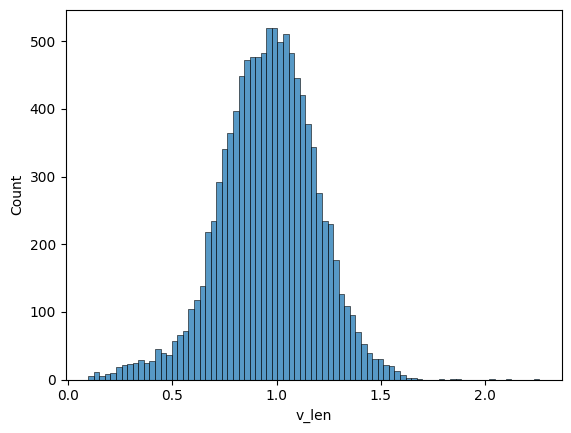

In [27]:
df = ds.to_dataframe().reset_index()
df['v_len'] = np.sqrt(df.v_x**2 + df.v_y**2)

print(f"pyorc vector length mean: {np.mean(df.v_len)}")
sns.histplot(
    data=df,
    x='v_len'
)